# Gaussian Process Demo

<font size='4'>
In this notebook, we look at Gaussian processes from a coding standpoint: how to compute a GP posterior, how to sample from a GP, and how to adjust GPs.
    </font>

<font size='4'>

Notably, the method for computing GP posteriors involves inverting an $N \times N$ matrix/solving an $N \times N$ matrix system, where $N$ is the size of the dataset. This makes computing a GP posterior an $O(N^3)$ process, which scales quite poorly. Numerous methods for mitigating this issue can be found in [Rasmussen and Williams, 2006]. For now, I will use the naive approach, as the examples in this notebook are small enough to be tractable.

</font>

<font size='4'>

Suppose the function $f$ (scalar-valued for now) to be modeled is a realization of a GP prior.

</font>

<font size='4'>

Predictive prior for function values $\mathbf{Y}$ evaluated at user-specified (deterministic) inputs $X$ with noisy observations:
    
\begin{align*}
    \mathbf{Y} = \mathbf{F}(X) + \epsilon, \quad \epsilon \sim \mathcal{N}(0, \sigma_n^2 \mathbf{I})
\end{align*}

Data set: $\{ X, Y \}$ ($Y$ is a realization of $\mathbf{Y}$) where $|X| = N$

</font>

In [1]:
# Imports
import numpy as np
import scipy
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns

# Set seaborn plotting style
sns.set_style('darkgrid')
np.random.seed(42)

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


<font size='4'>

For the GP prior, I use the squared exponential (RBF) kernel:
\begin{align*}
    k_0(x, x', \sigma_p, \ell) = \sigma_p^2 \ \mathrm{exp} \left( - \frac{1}{2} \left( \frac{\| x - x' \|_2}{\ell} \right)^2 \right)
\end{align*}
with hyperparameters $\ell = \sigma_p = 1$ (for now)

GP prior:
\begin{align*}
    \mathbf{F}(x) \sim \mathcal{G} \mathcal{P} \left( \mu_0(x), k_0(x, x) \right)
\end{align*}
where prior mean function $\mu_0 \equiv 0$ (for now)

</font>

In [14]:
# Define the exponentiated quadratic kernel 
def exponentiated_quadratic(xa, xb, hyperparams = {'l': 1, 'σp': 1}):
    """Exponentiated quadratic  with σ=1"""
    
    l = hyperparams['l']
    σp = hyperparams['σp']
    
    # L2 distance
    sq_norm = -0.5 * (scipy.spatial.distance.cdist(xa, xb, 'sqeuclidean') / l ** 2)
    
    return σp ** 2 * np.exp(sq_norm)

<font size='4'>
Sampling from the GP prior:
    </font>

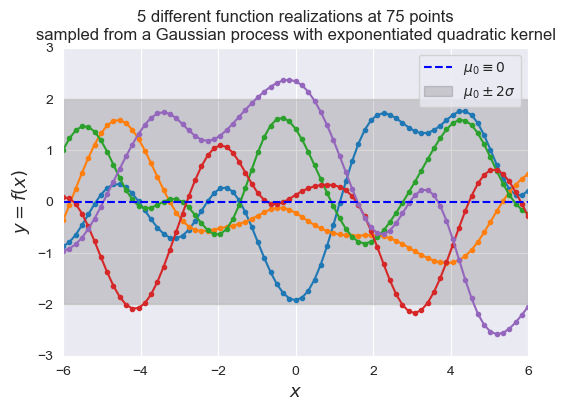

In [15]:
# Sample from the Gaussian process distribution
nb_of_samples = 75  # Number of points in each function
number_of_functions = 5  # Number of functions to sample
# Independent variable samples
X = np.expand_dims(np.linspace(-6, 6, nb_of_samples), 1)
Σ = exponentiated_quadratic(X, X)  # Kernel of data points

# Draw samples from the prior at our data points.
# Assume a mean of 0 for simplicity
ys = np.random.multivariate_normal(
    mean=np.zeros(nb_of_samples), cov=Σ, 
    size=number_of_functions)

# Plot the sampled functions
plt.figure(figsize=(6, 4))
for i in range(number_of_functions):
    plt.plot(X, ys[i], linestyle='-', marker='o', markersize=3)
    
plt.plot(X, [0 for x in X], 'b--', label='$\mu_0 \equiv 0$')
plt.fill_between(X.flat, -2, 2, color='black', 
                 alpha=0.15, label='$\mu_0 \pm 2\sigma$')

plt.xlabel('$x$', fontsize=13)
plt.ylabel('$y = f(x)$', fontsize=13)
plt.title((
    '5 different function realizations at 75 points\n'
    'sampled from a Gaussian process with exponentiated quadratic kernel'))
plt.xlim([-6, 6])
plt.ylim([-3, 3])
plt.legend()
plt.show()

<font size='4'>

$X_* = $ finite subset of $x$ values for which we wish to predict the $y$ values (size = $M$)
    
GP posterior:
\begin{align*}
    (\mathbf{F}(x) \ | \ \mathbf{Y} = Y) \sim \mathcal{G} \mathcal{P} \left( \mu_*(x), k_*(x, x) \right) \textrm{ where}
\end{align*}

\begin{align*}
    K &= k_0(X, X) \in \mathbb{R}^{N \times N}, & K_* &= k_0(X, X_*) \in \mathbb{R}^{N \times M}, \\ K_*^T &= k_0(X_*, X) \in \mathbb{R}^{M \times N}, & K_{**} &= k_0(X_*, X_*) \in \mathbb{R}^{M \times M}.
\end{align*}
        
\begin{align*}
    \mu_*(X_*) &= \mu_0(X_*) \ + \ K_{*}^T (K + \sigma_n^2 \mathbf{I})^{-1} (Y - \mu_0(X)) \\
    \Sigma_*(X_*) &= K_{**} \ - \ K_{*}^T (K + \sigma_n^2 \mathbf{I})^{-1} K_{*}
\end{align*}
    
Here, I use $\sigma_n^2 = 0$ (noiseless observations)

</font>

In [16]:
# Gaussian process posterior
def GP(X1, y1, X2, kernel_func, hyperparams = {'l': 1, 'σp': 1}, mean_func = lambda x: 0):
    """
    Calculate the posterior mean and covariance matrix for y2
    based on the corresponding input X2, the observations (y1, X1), 
    and the prior kernel function.
    """
    
    # Kernel of the observations
    Σ11 = kernel_func(X1, X1, hyperparams)
    
    # Kernel of observations vs to-predict
    Σ12 = kernel_func(X1, X2, hyperparams)
    
    # Solve
    solved = scipy.linalg.solve(Σ11, Σ12, assume_a='pos').T
    
    # Compute posterior mean
    μ2 = solved @ (y1 - mean_func(X1))
    
    # Compute posterior covariance
    Σ22 = kernel_func(X2, X2, hyperparams)
    Σ2 = Σ22 - (solved @ Σ12)

    return μ2, Σ2  # mean, covariance

<font size='4'>

Example: GP model for $f(x) = \sin x$ on $[-6, 6]$ with $8$ data points; inputs $X$ will be generated randomly in $[-4, 4]$
    
To sample GP, $75$ equispaced test points on $[-6, 6]$ are sampled from the GP posterior using the multivariate Gaussian distribution to form a piecewise linear function. This is done $5$ times to generate $5$ sample functions from the GP posterior.

</font>

<font size='4'>

Here's what $f(x) = \sin x$ looks like compared to the GP prior:

</font>

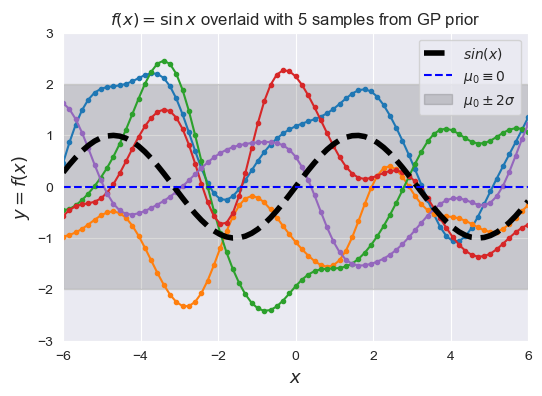

In [18]:
# Define the true function that we want to regress on
f_sin = lambda x: (np.sin(x)).flatten()

# Sample from the Gaussian process distribution
nb_of_samples = 75  # Number of points in each function
number_of_functions = 5  # Number of functions to sample
# Independent variable samples
X = np.expand_dims(np.linspace(-6, 6, nb_of_samples), 1)
Σ = exponentiated_quadratic(X, X)  # Kernel of data points

# Draw samples from the prior at our data points.
# Assume a mean of 0 for simplicity
ys = np.random.multivariate_normal(
    mean=np.zeros(nb_of_samples), cov=Σ, 
    size=number_of_functions)

# Plot the sampled functions
plt.figure(figsize=(6, 4))
for i in range(number_of_functions):
    plt.plot(X, ys[i], linestyle='-', marker='o', markersize=3)
    
plt.plot(X, f_sin(X), lw=4, linestyle='--', color='black', label='$sin(x)$')
plt.plot(X, [0 for x in X], 'b--', label='$\mu_0 \equiv 0$')
plt.fill_between(X.flat, -2, 2, color='black', 
                 alpha=0.15, label='$\mu_0 \pm 2\sigma$')

plt.xlabel('$x$', fontsize=13)
plt.ylabel('$y = f(x)$', fontsize=13)
plt.title((
    '$f(x) = \sin x$ overlaid with 5 samples from GP prior'))
plt.xlim([-6, 6])
plt.ylim([-3, 3])
plt.legend()
plt.show()

<font size='4'>

Now we compute the GP posterior:

</font>

In [19]:
# Compute the posterior mean and covariance

n1 = 8  # Number of points to condition on (training points)
n2 = 75  # Number of points in posterior (test points)
ny = 5  # Number of functions that will be sampled from the posterior
domain = (-6, 6)

# Sample observations (X1, y1) on the function
X1 = np.random.uniform(domain[0]+2, domain[1]-2, size=(n1, 1))
y1 = f_sin(X1)

# Predict points at uniform spacing to capture function
X2 = np.linspace(domain[0], domain[1], n2).reshape(-1, 1)

# Compute posterior mean and covariance
μ2, Σ2 = GP(X1, y1, X2, exponentiated_quadratic)

# Compute the standard deviation at the test points to be plotted
σ2 = np.sqrt(np.diag(Σ2))

# Draw some samples of the posterior
y2 = np.random.multivariate_normal(mean=μ2, cov=Σ2, size=ny)

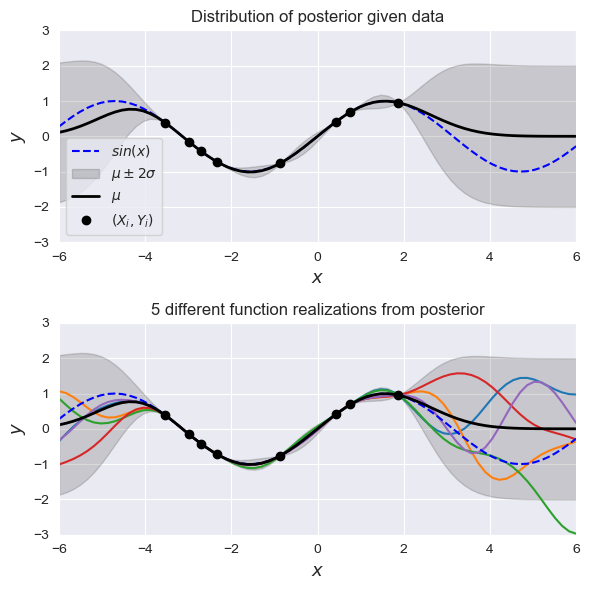

In [20]:
# Plot the posterior distribution and some samples
fig, (ax1, ax2) = plt.subplots(
    nrows=2, ncols=1, figsize=(6, 6))

# Plot the distribution of the function (mean, covariance)
ax1.plot(X2, f_sin(X2), 'b--', label='$sin(x)$')
ax1.fill_between(X2.flat, μ2-2*σ2, μ2+2*σ2, color='black', 
                 alpha=0.15, label='$\mu \pm 2\sigma$')
ax1.plot(X2, μ2, lw=2, color='black', label='$\mu$')
ax1.plot(X1, y1, 'ko', linewidth=2, label='$(X_i, Y_i)$')
ax1.set_xlabel('$x$', fontsize=13)
ax1.set_ylabel('$y$', fontsize=13)
ax1.set_title('Distribution of posterior given data')
ax1.axis([domain[0], domain[1], -3, 3])
ax1.legend()

# Plot some samples from this function
ax2.plot(X2, y2.T, '-')
ax2.plot(X2, f_sin(X2), 'b--', label='$sin(x)$')
ax2.fill_between(X2.flat, μ2-2*σ2, μ2+2*σ2, color='black', 
                 alpha=0.15, label='$\mu \pm 2\sigma$')
ax2.plot(X2, μ2, lw=2, color='black', label='$\mu$')
ax2.plot(X1, y1, 'ko', linewidth=2, label='$(X_i, Y_i)$')
ax2.set_xlabel('$x$', fontsize=13)
ax2.set_ylabel('$y$', fontsize=13)
ax2.set_title('5 different function realizations from posterior')
ax2.axis([domain[0], domain[1], -3, 3])
ax2.set_xlim([-6, 6])
plt.tight_layout()
plt.show()

<font size='4'>

The GP model performs well on $[-4, 4]$ but not beyond. This makes sense, as there is no data beyond this interval, making prediction difficult. As we extend beyond $[-4, 4]$ the uncertainty of the posterior approaches the uncertainty of the prior, which is $\sigma^2 = 1 \Rightarrow \mu_0 \pm 2 \sigma = 0 \pm 2$ using the RBF kernel with the standard hyperparameters $\ell = \sigma_p = 1$.

</font>

<font size='4'>

The function $f(x) = \sin x$ is a nice function; it's smooth and doesn't have an upward or downward trend. It also lies within the $2\sigma$ confidence interval of the GP prior, meaning our "initial guess" was good. What if we want to model a less nice function, like $f(x) = e^x$ on $[-5, 5]$ using the same GP prior?

</font>

In [8]:
# Compute the posterior mean and covariance

# Define the true function that we want to regress on
f_exp = lambda x: (np.exp(x)).flatten()

n1 = 8  # Number of points to condition on (training points)
n2 = 75  # Number of points in posterior (test points)
ny = 5  # Number of functions that will be sampled from the posterior
domain = (-6, 6)

# Sample observations (X1, y1) on the function
X1 = np.random.uniform(domain[0]+6, domain[1]-3, size=(n1 - 3, 1))
X1 = np.insert(X1, 0, -3., axis=0)
X1 = np.insert(X1, 0, -1., axis=0)
X1 = np.insert(X1, 0, 0., axis=0)
y1 = f_exp(X1)

# Predict points at uniform spacing to capture function
X2 = np.linspace(domain[0], domain[1], n2).reshape(-1, 1)

# Compute posterior mean and covariance
μ2, Σ2 = GP(X1, y1, X2, exponentiated_quadratic)

# Compute the standard deviation at the test points to be plotted
σ2 = np.sqrt(np.diag(Σ2))

# Draw some samples of the posterior
y2 = np.random.multivariate_normal(mean=μ2, cov=Σ2, size=ny)

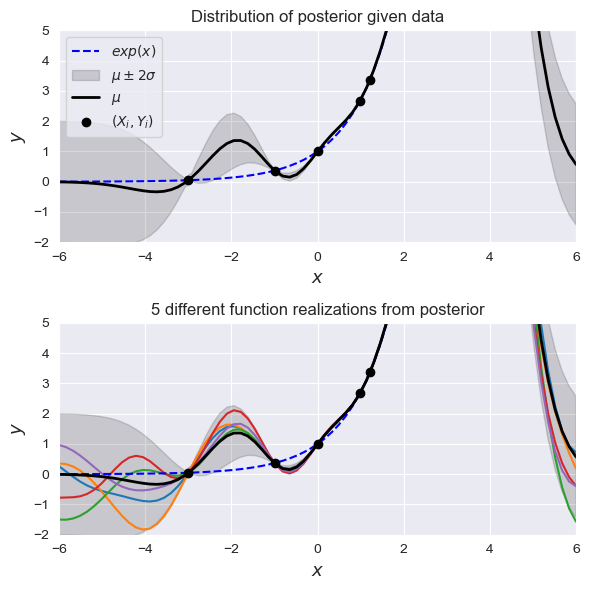

In [9]:
# Plot the posterior distribution and some samples
fig, (ax1, ax2) = plt.subplots(
    nrows=2, ncols=1, figsize=(6, 6))

# Plot the distribution of the function (mean, covariance)
ax1.plot(X2, f_exp(X2), 'b--', label='$exp(x)$')
ax1.fill_between(X2.flat, μ2-2*σ2, μ2+2*σ2, color='black', 
                 alpha=0.15, label='$\mu \pm 2\sigma$')
ax1.plot(X2, μ2, lw=2, color='black', label='$\mu$')
ax1.plot(X1, y1, 'ko', linewidth=2, label='$(X_i, Y_i)$')
ax1.set_xlabel('$x$', fontsize=13)
ax1.set_ylabel('$y$', fontsize=13)
ax1.set_title('Distribution of posterior given data')
ax1.set_xlim([-6, 6])
ax1.set_ylim([-2, 5])
ax1.legend()

# Plot some samples from this function
ax2.plot(X2, y2.T, '-')
ax2.plot(X2, f_exp(X2), 'b--', label='$exp(x)$')
ax2.fill_between(X2.flat, μ2-2*σ2, μ2+2*σ2, color='black', 
                 alpha=0.15, label='$\mu \pm 2\sigma$')
ax2.plot(X2, μ2, lw=2, color='black', label='$\mu$')
ax2.plot(X1, y1, 'ko', linewidth=2, label='$(X_i, Y_i)$')
ax2.set_xlabel('$x$', fontsize=13)
ax2.set_ylabel('$y$', fontsize=13)
ax2.set_title('5 different function realizations from posterior')
ax2.set_xlim([-6, 6])
ax2.set_ylim([-2, 5])
plt.tight_layout()
plt.show()

<font size='4'>

Notice that as we consider $x$ values beyond $[-3, 3]$, the model tends towards the prior ($\mu_0 \equiv 0$). This makes sense, as the posterior cannot reliably predict in this area due to the absence of data, so the model reverts to the prior. (See formulas for $\mu_*$ and $\Sigma_*$)
    
Additionally, this model seems to be inaccurate in $[-3, -1]$, as the mean function lies above the true function. The reason for this is that the other data in $[-1, 3]$ are "pulling" the mean up, as the data values increase rapidly in $[-1, 3]$. 
    
Recall that the kernel (covariance function) dictates how correlated function values are to one another, and is larger for points that are close together. This means that the GP model will tend to mimic data points nearby; since the data values are large, the model will be "pulled" upward near that data.
    
Since the correlation between function values is causing the mean to pull up and away from the true function, we may want to consider weakening the correlation between function evaluations at input values that are close together. This can be done by increasing the lengthscale $\ell$ in the RBF kernel. (I also adjust the amplitude $\sigma_p$ to make the confidence intervals large enough to see, but in practice these hyperparameters will typically be learned rather than chosen arbitrarily.)

</font>

In [10]:
# increasing lengthscale to 2.5
hyperparams = {'l': 2.5, 'σp': 80}

In [11]:
# Compute the posterior mean and covariance

# Define the true function that we want to regress on
f_exp = lambda x: (np.exp(x)).flatten()

μ2, Σ2 = GP(X1, y1, X2, exponentiated_quadratic, hyperparams)

# Compute the standard deviation at the test points to be plotted
σ2 = np.sqrt(np.diag(Σ2))

# Draw some samples of the posterior
y2 = np.random.multivariate_normal(mean=μ2, cov=Σ2, size=ny)

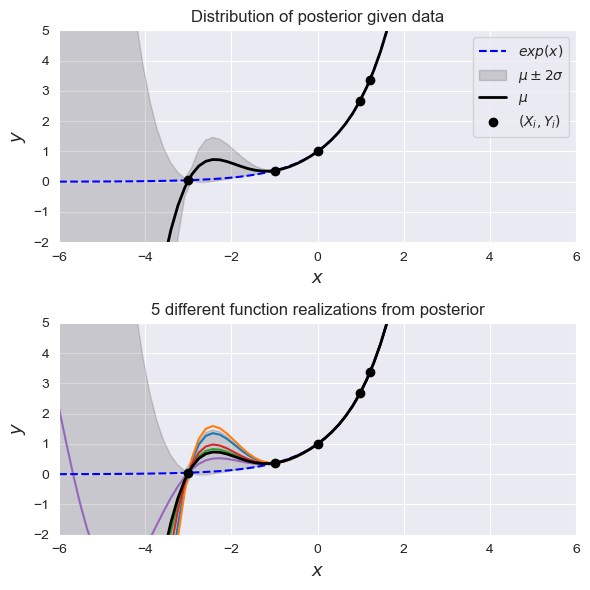

In [12]:
# Plot the posterior distribution and some samples
fig, (ax1, ax2) = plt.subplots(
    nrows=2, ncols=1, figsize=(6, 6))

# Plot the distribution of the function (mean, covariance)
ax1.plot(X2, f_exp(X2), 'b--', label='$exp(x)$')
ax1.fill_between(X2.flat, μ2-2*σ2, μ2+2*σ2, color='black', 
                 alpha=0.15, label='$\mu \pm 2\sigma$')
ax1.plot(X2, μ2, lw=2, color='black', label='$\mu$')
ax1.plot(X1, y1, 'ko', linewidth=2, label='$(X_i, Y_i)$')
ax1.set_xlabel('$x$', fontsize=13)
ax1.set_ylabel('$y$', fontsize=13)
ax1.set_title('Distribution of posterior given data')
ax1.set_xlim([-6, 6])
ax1.set_ylim([-2, 5])
ax1.legend()

# Plot some samples from this function
ax2.plot(X2, y2.T, '-')
ax2.plot(X2, f_exp(X2), 'b--', label='$exp(x)$')
ax2.fill_between(X2.flat, μ2-2*σ2, μ2+2*σ2, color='black', 
                 alpha=0.15, label='$\mu \pm 2\sigma$')
ax2.plot(X2, μ2, lw=2, color='black', label='$\mu$')
ax2.plot(X1, y1, 'ko', linewidth=2, label='$(X_i, Y_i)$')
ax2.set_xlabel('$x$', fontsize=13)
ax2.set_ylabel('$y$', fontsize=13)
ax2.set_title('5 different function realizations from posterior')
ax2.set_xlim([-6, 6])
ax2.set_ylim([-2, 5])
plt.tight_layout()
plt.show()

<font size='4'>

We can see that after adjusting the hyperparameters, the mean has improved somewhat. However, the uncertainty is much higher in the leftmost region due to the amplitude change. Additionally, if we increase $\ell$ any farther, we may run into ill-conditioning issues.

Unfortunately, hyperparameter tuning alone can only help so much here. To obtain a better model, we have two alternative options:

1) Gather more data.
2) Change the prior.
    
In applications, we may not have good prior knowledge of the underlying model if it is highly complex; however, if there are well-known approximations/parametrizations of the underlying model, we can incorporate this knowledge into the choice of the GP prior to obtain a better posterior.

</font>

<font size='4'>

Consider the $f(x) = e^x$ example. Suppose we know our model is exponential and we have a reasonably close estimate of the correct exponent, so we include an exponential function in our prior mean function, say $\mu_0(x) = e^{1.02x}$.

</font>

In [13]:
# back to original hyperparameters
hyperparams = {'l': 1, 'σp': 1}

In [14]:
# Compute the posterior mean and covariance

# Define the true function that we want to regress on
f_exp = lambda x: (np.exp(x)).flatten()

# Define prior based on knowledge
f_estimate = lambda x: (np.exp(1.02 * x)).flatten()

μ2, Σ2 = GP(X1, y1, X2, exponentiated_quadratic, hyperparams, mean_func = f_estimate)

# Compute the standard deviation at the test points to be plotted
σ2 = np.sqrt(np.diag(Σ2))

# Draw some samples of the posterior
y2 = f_estimate(X2) + np.random.multivariate_normal(mean=μ2, cov=Σ2, size=ny)

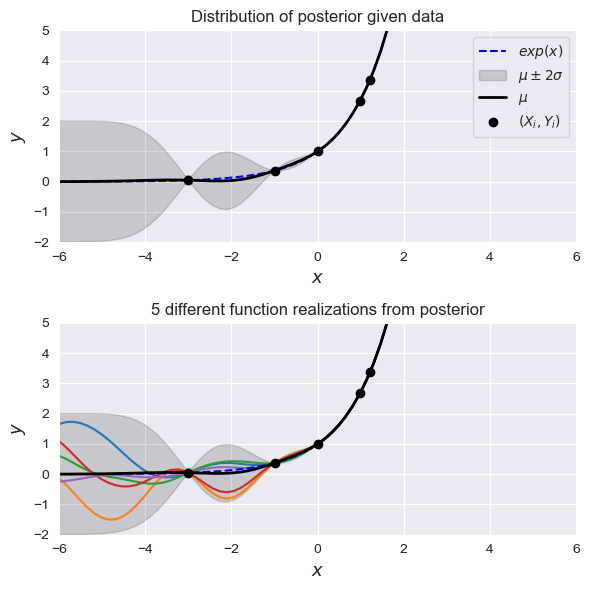

In [15]:
# Plot the posterior distribution and some samples
fig, (ax1, ax2) = plt.subplots(
    nrows=2, ncols=1, figsize=(6, 6))
# Plot the distribution of the function (mean, covariance)
ax1.plot(X2, f_exp(X2), 'b--', label='$exp(x)$')
ax1.fill_between(X2.flat, f_estimate(X2) + μ2-2*σ2, f_estimate(X2) + μ2+2*σ2, color='black', 
                 alpha=0.15, label='$\mu \pm 2\sigma$')
ax1.plot(X2, f_estimate(X2) + μ2, lw=2, color='black', label='$\mu$')
ax1.plot(X1, y1, 'ko', linewidth=2, label='$(X_i, Y_i)$')
ax1.set_xlabel('$x$', fontsize=13)
ax1.set_ylabel('$y$', fontsize=13)
ax1.set_title('Distribution of posterior given data')
ax1.set_xlim([-6, 6])
ax1.set_ylim([-2, 5])
ax1.legend()

# Plot some samples from this function
ax2.plot(X2, y2.T, '-')
ax2.plot(X2, f_exp(X2), 'b--', label='$exp(x)$')
ax2.fill_between(X2.flat, f_estimate(X2) + μ2-2*σ2, f_estimate(X2) + μ2+2*σ2, color='black', 
                 alpha=0.15, label='$\mu \pm 2\sigma$')
ax2.plot(X2, f_estimate(X2) + μ2, lw=2, color='black', label='$\mu$')
ax2.plot(X1, y1, 'ko', linewidth=2, label='$(X_i, Y_i)$')
ax2.set_xlabel('$x$', fontsize=13)
ax2.set_ylabel('$y$', fontsize=13)
ax2.set_title('5 different function realizations from posterior')
ax2.set_xlim([-6, 6])
ax2.set_ylim([-2, 5])
plt.tight_layout()
plt.show()

<font size='4'>

This is much better! We can see that incorporating prior knowledge has improved the quality of the model significantly.

</font>

<font size='4'>    

Note that the uncertainty does not care about how good the prior is, or what the actual $y$ values are in the data; it only cares how close the $x$ values are to the inputs $X$. Thus, this model will have the same size confidence intervals regardless of the prior mean function chosen, given the same dataset and hyperparameters. The uncertainty may be reduced only through gathering additional data or hyperparameter tuning.

</font>

<font size='4'>

Despite the versatility of GPs, there are some numerical issues to consider. For instance, one common issue with GPs is the conditioning of the $K$ and $K_{**}$ matrices, which can be very poor when the lengthscale $\ell$ is too large, the dataset is too large, or the data points are clustered together.

</font>